### Variational Autoencoder. 

In [92]:
import os

import numpy as np
from scipy.stats import norm
import torch
import torch.nn.functional as F
import torchvision as tv

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


### Load MNIST dataset.

In [93]:
transform = tv.transforms.Compose([tv.transforms.ToTensor()])
#transform = tv.transforms.Compose([tv.transforms.ToTensor(),
#                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
def make_mnist_loaders():
    datasets = {
        'train': tv.datasets.FashionMNIST(os.path.join('mnist', 'train'), 
                                   train=True, 
                                   download=True, 
                                   transform=transform),
        'test': tv.datasets.FashionMNIST(os.path.join('mnist', 'test'), 
                                  train=False, 
                                  download=True, 
                                  transform=transform),    
    }

    dataloaders = {
        name: torch.utils.data.DataLoader(value, batch_size=100, shuffle=True) for name, value in datasets.items()
    } 
    return dataloaders

def make_mnist_fashion_loaders():
    datasets = {
        'train': tv.datasets.FashionMNIST(os.path.join('mnist-fashion', 'train'), 
                                   train=True, 
                                   download=True, 
                                   transform=transform),
        'test': tv.datasets.FashionMNIST(os.path.join('mnist-fashion', 'test'), 
                                  train=False, 
                                  download=True, 
                                  transform=transform),    
    }

    dataloaders = {
        name: torch.utils.data.DataLoader(value, batch_size=100, shuffle=True) for name, value in datasets.items()
    } 
    return dataloaders



In [94]:
dataloader_mnist = make_mnist_loaders()
dataloader_mnist_fashion = make_mnist_fashion_loaders()

In [95]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, .5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

torch.Size([100, 1, 28, 28])

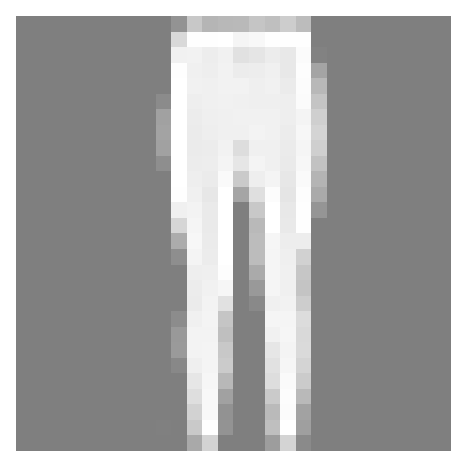

In [96]:
image, label = next(iter(dataloader_mnist_fashion['train']))
imshow(image[0])
image.shape

### Define model for training Variational Auto Encoder.

In [97]:
class Model(torch.nn.Module):
    def __init__(self, input_size, code_size, hidden_size):
        super(Model, self).__init__()
        self.code_size = code_size # size of latent vector z.
        self.input_size = input_size
        self.encoder_fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc_mu = torch.nn.Linear(hidden_size, code_size)
        self.fc_logvar = torch.nn.Linear(hidden_size, code_size)
        
        self.decoder_fc1 = torch.nn.Linear(code_size, hidden_size)
        self.decoder_fc2 = torch.nn.Linear(hidden_size, input_size)

    def fit(self, dataloader, device, num_epochs, learn_rate):
        """
        """    
        optimizer  = torch.optim.Adam(self.parameters(), lr=learn_rate)

        train_loss = []
        test_loss = []
        for epoch in range(num_epochs):
            acc = []
            for x, _ in iter(dataloader('train')):
                self.train()v
                x = x.to(device)
                optimizer.zero_grad()
                x_hat, mu, logvar = self.forward(x)
                loss = Model.vae_loss(x_hat, x, mu, logvar)
                acc.append(loss.item())
                loss.backward()
                optimizer.step()
            train_loss.append(np.mean(acc))
            loss = self.validate(dataloader('test'), device)
            test_loss.append(loss)
            print("Epoch={} Loss={}".format(epoch, loss))
        return train_loss, test_loss
    
    def validate(self, dataloader, device):
        self.eval()
        with torch.no_grad():
            acc = []
            for x, _ in iter(dataloader):
                x = x.to(device)
                x_hat, mu, logvar = self.forward(x)
                loss = Model.vae_loss(x_hat, x, mu, logvar)
                acc.append(loss.item())
            return np.mean(acc)
        
    def encode(self, x):
        """ VAE encoder step.
            Return vectors mu and log_variance for
            distribution Q(z|x) that approximates P(z|x).
        """
        h = F.relu(self.encoder_fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def decode(self, z):
        """ VAE decoder step.
            Return reconstructed vector x_hat.
        """
        h = F.relu(self.decoder_fc1(z))
        return torch.sigmoid(self.decoder_fc2(h))

    def reparam(self, mu, logvar):
        """ Return vector representing latent state `z`.
            Sample `z` - latent vector - from 
            distribution Q(z|x).
        """
        if self.training:
            sigma = torch.exp(0.5*logvar)
            e = torch.randn_like(sigma)
            return e.mul(sigma).add_(mu)
        else:
            return mu
        
    def forward(self, x):
        """ Forward step VAE encoder / decoder.
        """
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar
    
    def infer(self, x):
        """ Return z - latent state sampled from Q(z|x)
        """
        self.eval()
        with torch.no_grad():
            mu, logvar = self.encode(x.view(-1, self.input_size))
            return self.reparam(mu, logvar)
        
    @staticmethod
    def vae_loss(x_hat, x, mu, log_variance):
        """ Return value of lower bound of data log likelihood:
                sum of reconstruction error and divergence between
                Q(z|x) and P(z|x).
        """
        batch_size, x_size = x_hat.shape
        bce = F.binary_cross_entropy(x_hat, x.view(-1, x_size))

        divergence = -0.5 * torch.sum(1. + log_variance - mu.pow(2) - log_variance.exp())
        divergence /= (batch_size * x_size)
        return bce + divergence


In [98]:
def make_device(use_gpu):
    """ Return device.
    """
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu") \
           if use_gpu \
           else torch.device("cpu")

In [99]:
N = 28*28
model = Model(N, 2, 500)
device = make_device(True)
model.to(device)
_, _ = model.fit(lambda name: dataloader_mnist_fashion[name], device, 20, 0.001)


Epoch=0 Loss=0.350078949034214
Epoch=1 Loss=0.344788718521595
Epoch=2 Loss=0.34207493513822557
Epoch=3 Loss=0.3399628522992134
Epoch=4 Loss=0.3385554775595665
Epoch=5 Loss=0.33730166524648664
Epoch=6 Loss=0.33649159282445906
Epoch=7 Loss=0.3355139368772507
Epoch=8 Loss=0.3353038051724434
Epoch=9 Loss=0.3347192579507828
Epoch=10 Loss=0.334658984541893
Epoch=11 Loss=0.33439866691827774
Epoch=12 Loss=0.3339727571606636
Epoch=13 Loss=0.33416452407836916
Epoch=14 Loss=0.33395123064517973
Epoch=15 Loss=0.3333403146266937
Epoch=16 Loss=0.33298242688179014
Epoch=17 Loss=0.3336371684074402
Epoch=18 Loss=0.3323171272873878
Epoch=19 Loss=0.3324926972389221


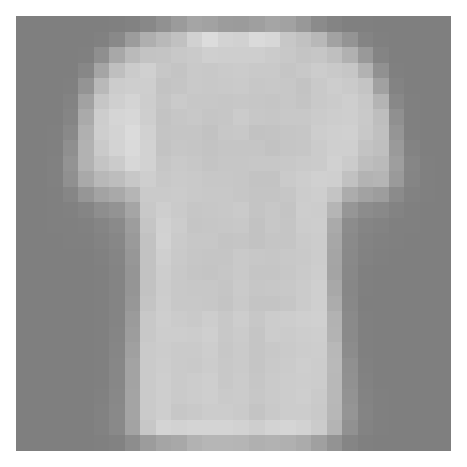

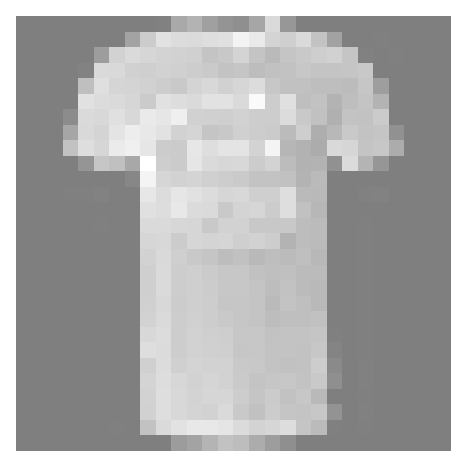

In [108]:
model.eval()
with torch.no_grad():
    for x, y in iter(dataloader_mnist_fashion['test']):
        x_hat, _, _ = model.forward(x)
        im = x_hat.detach().numpy()
        im.resize(x_hat.shape[0], 1, 28, 28)
        imshow(torch.Tensor(im[0]))
        im = x.detach().numpy()
        im.resize(x_hat.shape[0], 1, 28, 28)
        imshow(torch.Tensor(im[0]))
                 
          # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
        n = min(x.size(0), 8)
        comparison = torch.cat([x[:n],
                                  x_hat.view(x.shape[0], 1, 28, 28)[:n]])
        tv.utils.save_image(comparison.data.cpu(),
                     'reconstruction_' + str(1) + '.png', nrow=n)

        break

### Visualize clustering.

In [101]:
def plot_hidden_state(model, dataloader):
    x1 = []
    x2 = []
    label = []
    for x, y in iter(dataloader):
        z = model.infer(x)
        x1.extend(z[:, 0].numpy())
        x2.extend(z[:, 1].numpy())
        label.extend(y)
    plt.scatter(x1, x2, c=label, cmap='tab10')
    plt.colorbar()
    plt.show() 

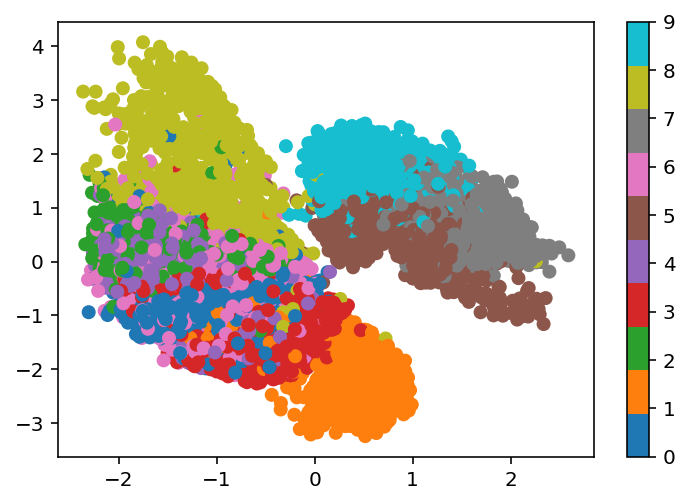

In [107]:
plot_hidden_state(model, dataloader_mnist_fashion['test'])

### Sample items from 2D latent space.

In [105]:
def sample_latent_space(model, num_items=10, size=28):  
    """Display a 2D manifold of the digits
    """
    figure = np.zeros((size * num_items, size * num_items))

    # Construct grid of latent variable values
    grid_x = norm.ppf(np.linspace(0.05, 0.95, num_items))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, num_items))

    # decode for each square in the grid
    model.eval()
    with torch.no_grad():
        for i, xi in enumerate(grid_x):
            for j, yi in enumerate(grid_y):
                z_sample = torch.from_numpy(np.array([xi, yi])).float()
                x_hat = model.decode(z_sample)
                im = x_hat.reshape(size, size)
                figure[i * size: (i + 1) * size,
                       j * size: (j + 1) * size] = im

    plt.figure(figsize=(10, 10))
    plt.imshow(figure)#, cmap='gnuplot2')
    plt.show()  

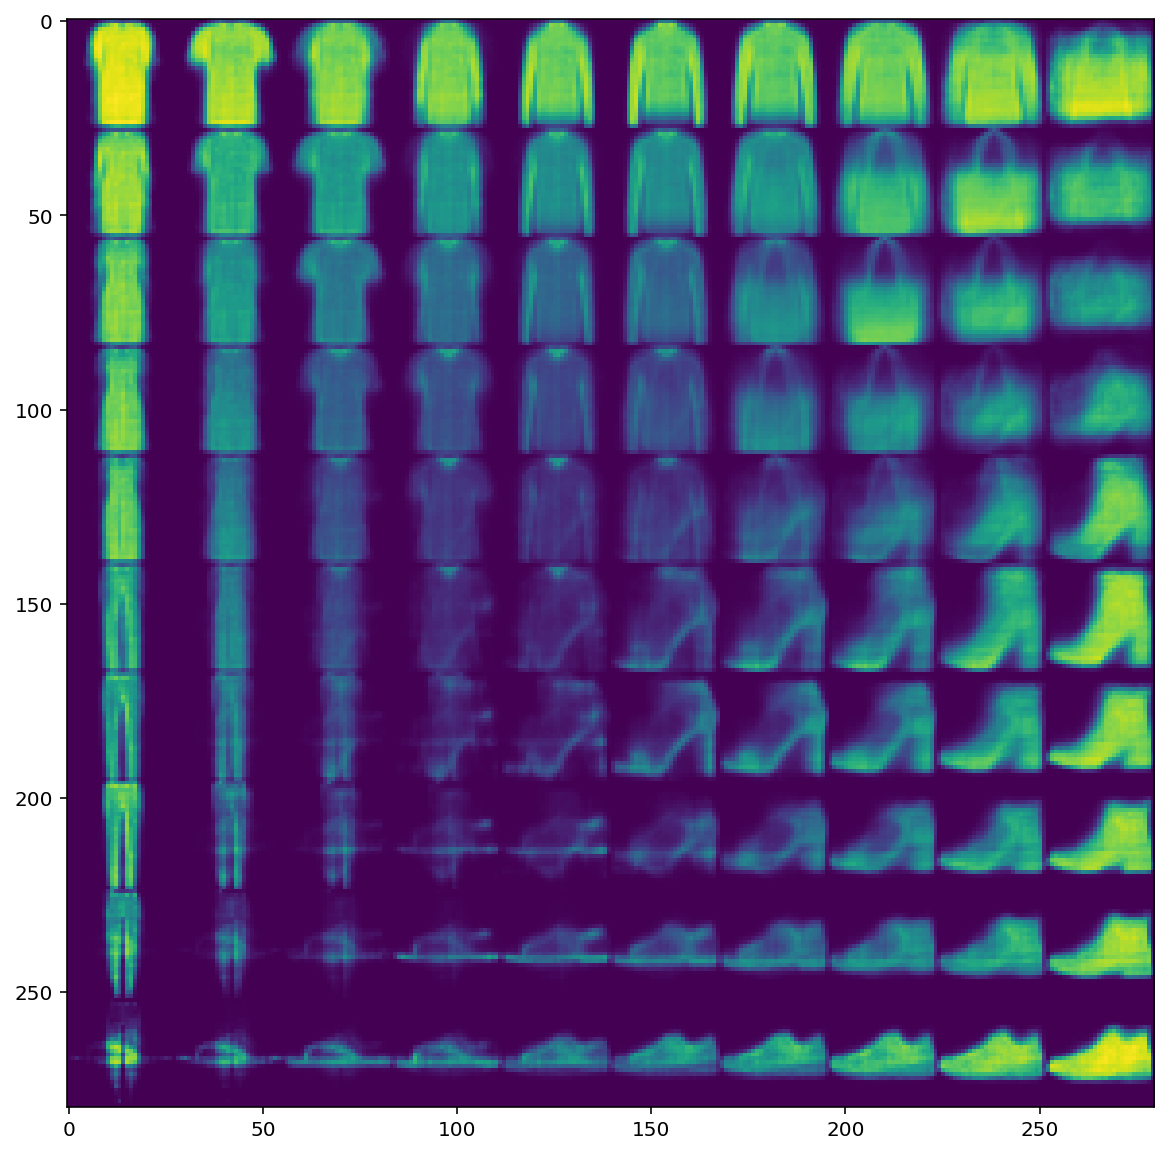

In [109]:
sample_latent_space(model, num_items=10)